In [1]:
from eos_core.user_defined import *
from eos_core.si import *
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style("ticks")
sns.set_palette("Dark2")
sns.set_context("talk")

In [3]:
RGAS / NAV / ANGSTROM**3 / (KILOGRAM / METER / SECOND**2 / KELVIN)

13806490.0

In [8]:
KB / ANGSTROM**3

1.380649e7 m^-1 kg s^-2 K^-1

> In this tutorial, we will implement the Peng-Robinson equation of state in python.

# Implementing a `UserDefinedEos`

To implement an equation of state in python, we have to define a `class` that has to contain the following methods:

- `components(self) -> int`: Returns the number of components (usually inferred from the shape of the input parameters).
- `molar_weight(self) -> SIArray1`: Returns an `SIArray1` with size equal to the number of components containing the molar mass of each component.
- `max_density(self, moles: np.ndarray[float]) -> float`: Returns the maximum allowed number density in units of `molecules/Angstrom³`.
- `helmholtz_energy(self, state: StateHD) -> Dual`: Returns the helmholtz energy as (hyper)-dual number given a `StateHD`.

## Implementing `helmholtz_energy` and the `StateHD` object.

`FeOs` computes properties from the helmholtz energy function using generalized (hyper)-dual numbers as input data types for automatic differentation.
Let's go through an example and see what the code does when we compute a property, e.g. the `pressure`.

1. The pressure is defined as $p = - \left( \frac{\partial A}{\partial V} \right)_{T, \mathbf{N}}$. Hence, to compute the pressure, we need **the first derivative of the helmholtz energy with respect to the volume**.
2. When we call the `pressure` method of a `State`, internally an intermediary object is created called `StateHD`.
3. `StateHD` contains information about temperature, amount of substance (moles) and the volume of the system just like `State` but **as generalized (hyper)-dual numbers instead of dimensioned values**. When computing the pressure, the data types are `Dual64` since we only need the first derivative.
4. Since we need the derivative w.r.t volume, **the non-real part of the `StateHD`'s volume is set to unity**.
5. The **`StateHD` is handed over to our python implementation of `helmholtz_energy`**.
6. We can access properties of the state (`StateHD`) by writing `state.temperature`, `state.density`, `state.volume` and so on.

In [11]:
from eos_core.user_defined import *
from eos_core.si import *

print_state = False

class PengRobinson:
    def helmholtz_energy(self, state):
        print("t: {}".format(state.temperature))
        print("v: {}".format(state.volume))
        print("n: {}".format(state.moles))
        a = ((1.0 - np.sqrt(state.temperature / self.tc)) * self.kappa + 1.0)**2 * self.a_r
        v = state.volume
        n = np.sum(state.moles)
        a_rt = n * (np.log(v / (v - self.b * n)) - a / (self.b * np.sqrt(2) * 2.0 * state.temperature)
            * np.log((v * (np.sqrt(2) - 1.0) + self.b * n) / (v * (np.sqrt(2) + 1.0) - self.b * n)))
        return a_rt
    
    def __init__(self, tc, pc, omega, mw):
        self.tc = tc / KELVIN
        self.omega = omega
        self.mw = np.array([mw / (GRAM / MOL)]) * GRAM / MOL
        self.a_r = 0.45724 * tc**2 * RGAS / pc / ANGSTROM**3 / NAV / KELVIN
        self.b = 0.07780 * tc * RGAS / pc / ANGSTROM**3 / NAV
        self.kappa = 0.37464 + (1.54226 - 0.26992 * omega) * omega
                
    def components(self): 
        return 1
    
    def get_subset(self, i):
        return self
        
    def molar_weight(self):
        return self.mw
    
    def max_density(self, moles):
        b = np.sum(moles * self.b) / np.sum(moles);
        return 0.9 / b

```python
class PengRobinson:
    # initialization omitted
    def helmholtz_energy(self, state):
            print("t: {}".format(state.temperature))
            print("v: {}".format(state.volume))
            print("n: {}".format(state.moles))
            a = ((1.0 - np.sqrt(state.temperature / self.tc)) * self.kappa + 1.0)**2 * self.a_r
            v = state.volume
            n = np.sum(state.moles)
            a_rt = n * (np.log(v / (v - self.b * n)) - a / (self.b * SQRT_2 * 2.0 * state.temperature)
                * np.log((v * (SQRT_2 - 1.0) + self.b * n) / (v * (SQRT_2 + 1.0) - self.b * n)))
            return a_rt
``` 

In [32]:
n_hexane = { 
    "mw": 86.175 * GRAM / MOL, "tc": 507.82 * KELVIN, 
    "pc": 30.4 * BAR, "omega": np.array([0.3003])
}
eos = UserDefinedEos(PengRobinson(**n_hexane))

In [35]:
state = State(eos, temperature=300*KELVIN, volume=215.85*ANGSTROM**3)

In [36]:
state.molar_helmholtz_energy() # .dp_dt() # .pressure()

t: 300.0
v: 215.85
n: [1.0]


-8.49194909880421e3 J/mol

In [39]:
State.critical_point(eos).pressure()

t: 300 + [1]ε + [0 + [0]ε]ε1 + [0 + [0]ε]ε2 + [0 + [0]ε]ε1ε2
v: 664.5617376827972 + [-0]ε + [0 + [0]ε]ε1 + [0 + [0]ε]ε2 + [0 + [0]ε]ε1ε2
n: [1 + [0]ε + [1 + [0]ε]ε1 + [1 + [0]ε]ε2 + [0 + [0]ε]ε1ε2]
t: 300 + [1]ε + 0 + [0]εv1 + 0 + [0]εv2 + 0 + [0]εv3
v: 664.5617376827972 + [-0]ε + 0 + [0]εv1 + 0 + [0]εv2 + 0 + [0]εv3
n: [1 + [0]ε + 1 + [0]εv1 + 0 + [0]εv2 + 0 + [0]εv3]
t: 300 + [0]ε + [0 + [0]ε]ε1 + [0 + [0]ε]ε2 + [0 + [0]ε]ε1ε2
v: 664.5617376827972 + [-441642.303191979]ε + [0 + [0]ε]ε1 + [0 + [0]ε]ε2 + [0 + [0]ε]ε1ε2
n: [1 + [0]ε + [1 + [0]ε]ε1 + [1 + [0]ε]ε2 + [0 + [0]ε]ε1ε2]
t: 300 + [0]ε + 0 + [0]εv1 + 0 + [0]εv2 + 0 + [0]εv3
v: 664.5617376827972 + [-441642.303191979]ε + 0 + [0]εv1 + 0 + [0]εv2 + 0 + [0]εv3
n: [1 + [0]ε + 1 + [0]εv1 + 0 + [0]εv2 + 0 + [0]εv3]
t: 375 + [1]ε + [0 + [0]ε]ε1 + [0 + [0]ε]ε2 + [0 + [0]ε]ε1ε2
v: 691.5936890640284 + [-0]ε + [0 + [0]ε]ε1 + [0 + [0]ε]ε2 + [0 + [0]ε]ε1ε2
n: [1 + [0]ε + [1 + [0]ε]ε1 + [1 + [0]ε]ε2 + [0 + [0]ε]ε1ε2]
t: 375 + [1]ε + 0 + [0]εv1 +

3.0397783872523605 MPa

In [251]:
dia = PhaseDiagramBinary.new_pxy(eos, 100.0*KELVIN, 101)

RuntimeError: System is supercritical.

In [21]:
%%time
s = State.critical_point(eos)

t: 300 + [1]ε + [0 + [0]ε]ε1 + [0 + [0]ε]ε2 + [0 + [0]ε]ε1ε2
v: 663.6633191043778 + [-0]ε + [0 + [0]ε]ε1 + [0 + [0]ε]ε2 + [0 + [0]ε]ε1ε2
n: [1 + [0]ε + [1 + [0]ε]ε1 + [1 + [0]ε]ε2 + [0 + [0]ε]ε1ε2]
t: 300 + [1]ε + 0 + [0]εv1 + 0 + [0]εv2 + 0 + [0]εv3
v: 663.6633191043778 + [-0]ε + 0 + [0]εv1 + 0 + [0]εv2 + 0 + [0]εv3
n: [1 + [0]ε + 1 + [0]εv1 + 0 + [0]εv2 + 0 + [0]εv3]
t: 300 + [0]ε + [0 + [0]ε]ε1 + [0 + [0]ε]ε2 + [0 + [0]ε]ε1ε2
v: 663.6633191043778 + [-440449.00112463924]ε + [0 + [0]ε]ε1 + [0 + [0]ε]ε2 + [0 + [0]ε]ε1ε2
n: [1 + [0]ε + [1 + [0]ε]ε1 + [1 + [0]ε]ε2 + [0 + [0]ε]ε1ε2]
t: 300 + [0]ε + 0 + [0]εv1 + 0 + [0]εv2 + 0 + [0]εv3
v: 663.6633191043778 + [-440449.00112463924]ε + 0 + [0]εv1 + 0 + [0]εv2 + 0 + [0]εv3
n: [1 + [0]ε + 1 + [0]εv1 + 0 + [0]εv2 + 0 + [0]εv3]
t: 375 + [1]ε + [0 + [0]ε]ε1 + [0 + [0]ε]ε2 + [0 + [0]ε]ε1ε2
v: 690.6587659840727 + [-0]ε + [0 + [0]ε]ε1 + [0 + [0]ε]ε2 + [0 + [0]ε]ε1ε2
n: [1 + [0]ε + [1 + [0]ε]ε1 + [1 + [0]ε]ε2 + [0 + [0]ε]ε1ε2]
t: 375 + [1]ε + 0 + [0]ε

In [13]:
state = State(eos, temperature=300*KELVIN, pressure=2.0*BAR)

In [15]:
print_state = True
state.pressure()

199.99999999998883 kPa

In [5]:
print("Critical properties (computed vs. input)")
print(f"rel. dev. t_c = {((523.0 * KELVIN - s.temperature) / 523.0 / KELVIN) * 100:.4f} %")
print(f"rel. dev. p_c = {((25.0 * BAR - s.pressure()) / 25.0 / BAR) * 100:.4f} %")

Critical properties (computed vs. input)
rel. dev. t_c = 0.0024 %
rel. dev. p_c = 0.0075 %


In [7]:
dia = PhaseDiagramPure(eos, 330.0 * KELVIN, 500)

/tmp/ipykernel_4867/3096424269.py:43: RuntimeWarning: invalid value encountered in log
  a_rt = n * (np.log(v / (v - b * n)) - a_k / (b * SQRT_2 * 2.0 * state.temperature)
/tmp/ipykernel_4867/3096424269.py:44: RuntimeWarning: invalid value encountered in log
  * np.log((v * (SQRT_2 - 1.0) + b * n) / (v * (SQRT_2 + 1.0) - b * n)))


In [8]:
data_dia = pd.DataFrame(dia.to_dict())

In [16]:
data_dia.head()

,pressure,density liquid,temperature,molar enthalpy liquid,molar enthalpy vapor,molar entropy liquid,molar entropy vapor,density vapor
0,0.563592,5884.785724,330.000000,4.997640,32.836022,0.046825,0.131183,21.210226
1,0.570571,5881.507635,330.386748,5.007409,32.828417,0.046854,0.131061,21.454399
2,0.577618,5878.223451,330.773496,5.017195,32.820796,0.046883,0.130939,21.700763
3,0.584733,5874.933156,331.160244,5.027000,32.813159,0.046912,0.130818,21.949332
4,0.591916,5871.636730,331.546992,5.036822,32.805506,0.046942,0.130696,22.200119


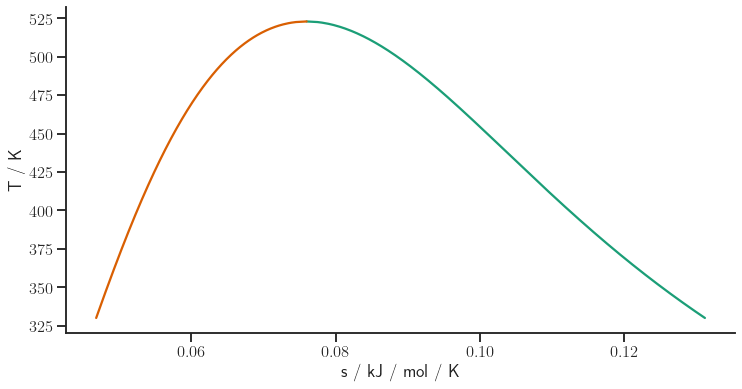

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=data_dia, x="molar entropy vapor", y="temperature", ax=ax)
sns.lineplot(data=data_dia, x="molar entropy liquid", y="temperature", ax=ax)
ax.set_xlabel('s / kJ / mol / K')
ax.set_ylabel('T / K')
sns.despine();

In [23]:
np.array([1.0 * MOL, 2.0 * MOL]) / MOL

TypeError: not implemented!

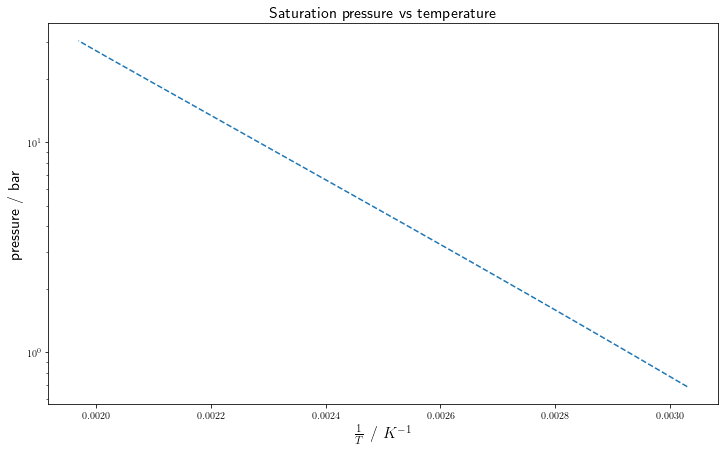

In [70]:
plt.figure(figsize=(12, 7))
plt.plot(1.0 / (dia.temperature / KELVIN), dia.pressure / BAR, "--")
plt.xlabel(r"$\frac{1}{T}$ / $K^{-1}$", fontsize=16)
plt.ylabel("pressure / bar", fontsize=16)
plt.yscale("log")
plt.title("Saturation pressure vs temperature", fontsize=16);